# Essentially a copy of [this Colab NB](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX?usp=sharing) from Chris McCormick and Nick Ryan.

In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# <span style="color:#FF8800"> (Most) Installs

In [2]:
!pip install transformers

     |████████████████████████████████| 1.1MB 4.7MB/s 
     |████████████████████████████████| 3.0MB 29.9MB/s 
     |████████████████████████████████| 890kB 51.0MB/s 
     |████████████████████████████████| 1.1MB 48.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9c3678df5eee929a2fa5fc71dccf4c2aca5a0ecbe8f863271d9d9055e739214b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
#standard library imports
import itertools

#3rd party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

#local app & library specific imports
from scipy.special import softmax
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# <span style="color:#FF8800"> Setup & global vars

In [4]:
# alert for cells
from IPython.display import Audio

alert = Audio(np.sin(np.linspace(0, 3000, 20000)), rate=20000, autoplay=True)

In [5]:
%cd drive/'My Drive'/propaganda_bert/

/content/drive/My Drive/propaganda_bert


In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
#Global vars - use those from the best experimental run

MODEL = "distilbert-base-cased" # depends on the model being used. Options include: "bert-base-cased" or "distilbert-base-cased"
BATCH_SIZE = 32
max_len = 204

output_dir = "binary_model/" # current options: "selected_model/" or "binary_model/"

# Load saved model

In [8]:
if MODEL == "bert-base-cased":

  from transformers import BertTokenizer, BertForSequenceClassification

  # Load a trained model and vocabulary that you have fine-tuned
  model = BertForSequenceClassification.from_pretrained(output_dir)
  tokenizer = BertTokenizer.from_pretrained(output_dir)

elif MODEL == "distilbert-base-cased":

  from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

  # Load a trained model and vocabulary that you have fine-tuned
  model = DistilBertForSequenceClassification.from_pretrained(output_dir)
  tokenizer = DistilBertTokenizer.from_pretrained(output_dir)

else:
  raise ValueError('Unknown model specified. Check MODEL var.')

# Copy the model to the GPU.
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [23]:
label2id = model.config.label2id # these are the labels the model already "knows"

if len(label2id.items())>2:
  THESE_LABELS = 'label'
else:
  THESE_LABELS = 'label_binary'

label2id

{'No_Propaganda': 0, 'Propaganda': 1}

# Load dev data

In [26]:
# Load the dataset into a pandas dataframe.
dev_df = pd.read_csv(
    "datasets/dev_data.tsv",
    sep = "\t",
    header = 0,
    index_col = 0
) 

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(dev_df.shape[0]))

dev_df["label_encoded"] = dev_df[THESE_LABELS].map(label2id) # use same mapping from model

sentences = dev_df.text.values

Number of test sentences: 2,850



# Tokenize dev data

In [27]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_dataloader = DataLoader(prediction_data, batch_size = BATCH_SIZE)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Generate predictions & evaluate results

In [28]:
# Prediction on test set

print('Predicting labels for {:,} dev sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask = batch

  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

alert

Predicting labels for 2,850 dev sentences...
    DONE.


# plot_confusion_matrix()

In [29]:
def plot_confusion_matrix(cm,target_names, title = 'Confusion matrix', cmap = None, normalize = True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(30, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Multi-class classification

In [30]:
#Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis = 0)

predicted_probs = softmax(flat_predictions)

dev_df["predicted_label"] = np.argmax(predicted_probs, axis = 1) #Find the index of highest predicted probability, this is the predicted label

In [31]:
dev_df.sample(3)

,label,label_binary,text,label_encoded,predicted_label
2745,No_Propaganda,No_Propaganda,Trump in order to prevent Trump from making pe...,0,0
829,No_Propaganda,No_Propaganda,by making them available to people online.\nSe...,0,0
80,No_Propaganda,No_Propaganda,the case – which drew a slew of support from o...,0,0


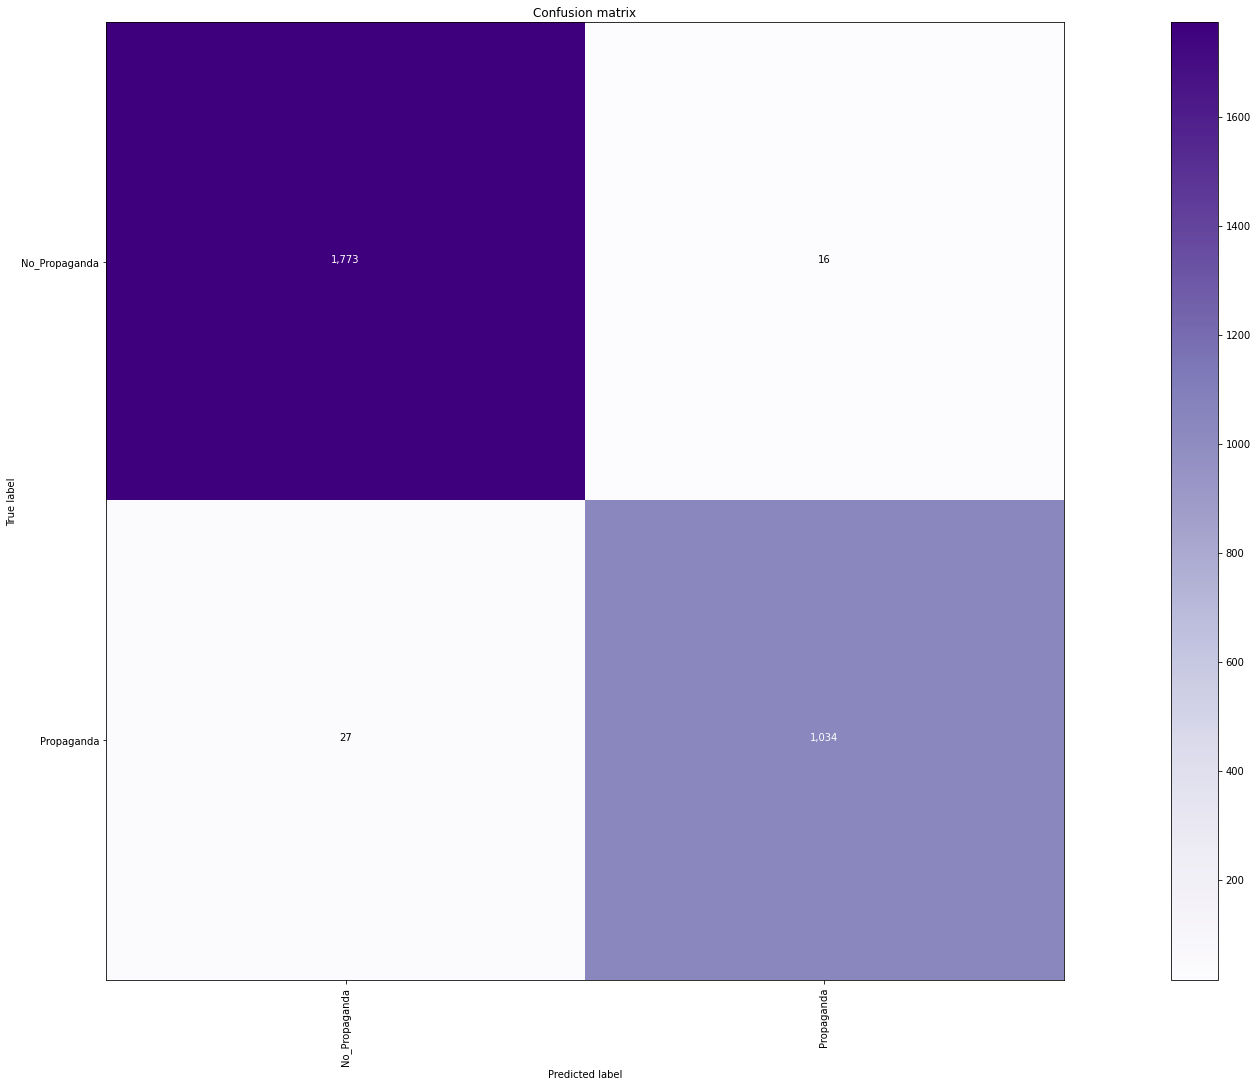

In [32]:
cm = confusion_matrix(dev_df["label_encoded"], dev_df["predicted_label"])
plot_confusion_matrix(cm = cm, target_names = label2id.keys(), normalize = False)

In [33]:
print(
    classification_report(
        y_true = dev_df["label_encoded"], 
        y_pred = dev_df["predicted_label"], 
        target_names = label2id.keys(), 
        zero_division = 0        
    )
)

               precision    recall  f1-score   support

No_Propaganda       0.98      0.99      0.99      1789
   Propaganda       0.98      0.97      0.98      1061

     accuracy                           0.98      2850
    macro avg       0.98      0.98      0.98      2850
 weighted avg       0.98      0.98      0.98      2850



# Binary classification

In [34]:
dev_df["predicted_label_binary"] = dev_df.apply(lambda x: "No_Propaganda" if x["predicted_label"]== label2id["No_Propaganda"] else "Propaganda", axis = 1)

In [35]:
dev_df.sample(3)

,label,label_binary,text,label_encoded,predicted_label,predicted_label_binary
2450,"Bandwagon,Reductio_ad_hitlerum",Propaganda,Such measures are common practice in North Kor...,1,0,No_Propaganda
2414,No_Propaganda,No_Propaganda,Trump has taken to reduce the extremely danger...,0,0,No_Propaganda
50,No_Propaganda,No_Propaganda,.\nI found the picture at right on a Mugshots ...,0,0,No_Propaganda


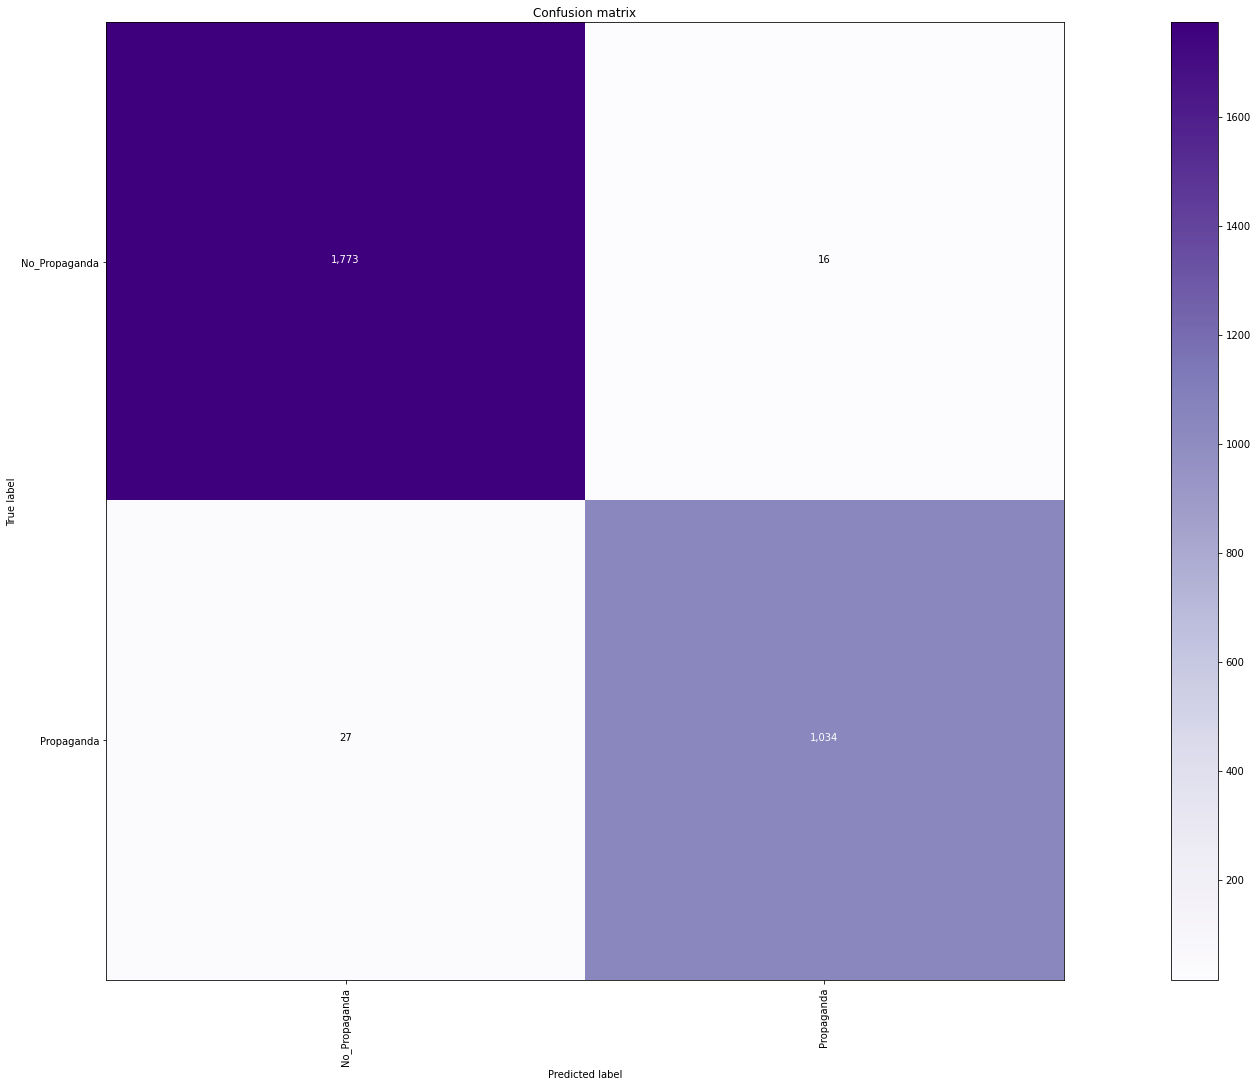

In [36]:
cm = confusion_matrix(
    y_true = dev_df["label_binary"], 
    y_pred = dev_df["predicted_label_binary"]
)

plot_confusion_matrix(cm = cm, target_names = ["No_Propaganda", "Propaganda"], normalize = False)

In [37]:
print(
    classification_report(
        y_true = dev_df["label_binary"], 
        y_pred = dev_df["predicted_label_binary"], 
        target_names = ["No_Propaganda", "Propaganda"], 
        zero_division = 0        
    )
)

               precision    recall  f1-score   support

No_Propaganda       0.98      0.99      0.99      1789
   Propaganda       0.98      0.97      0.98      1061

     accuracy                           0.98      2850
    macro avg       0.98      0.98      0.98      2850
 weighted avg       0.98      0.98      0.98      2850



# END